In [208]:
from reservoirUtils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['i']

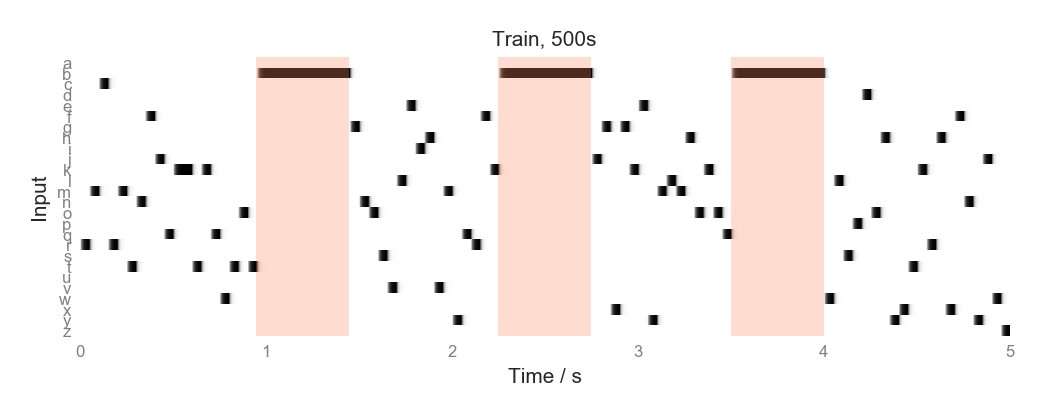

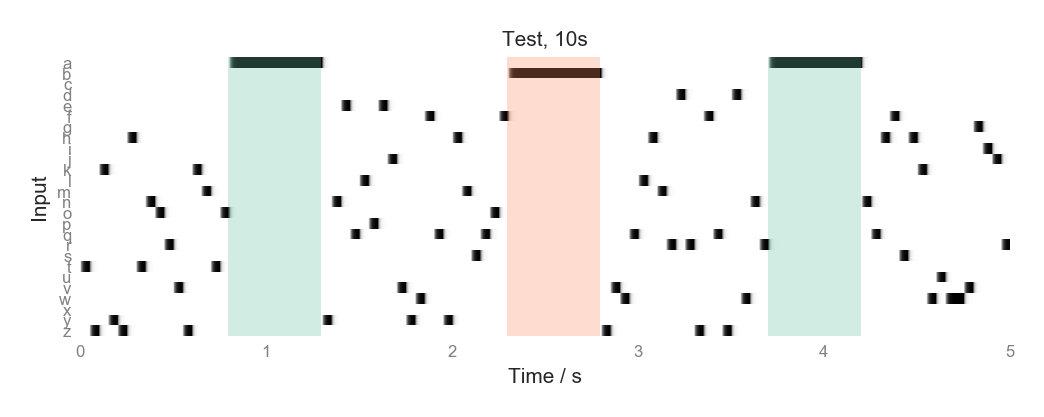

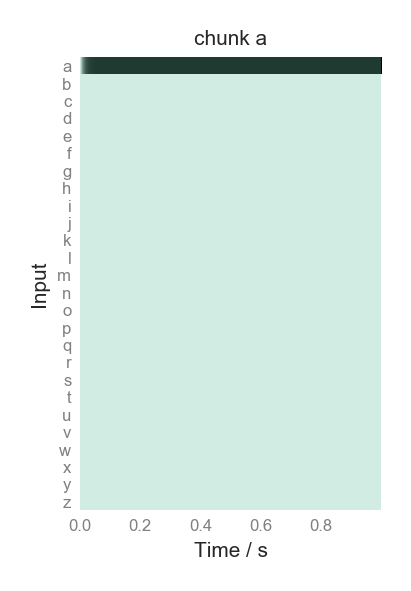

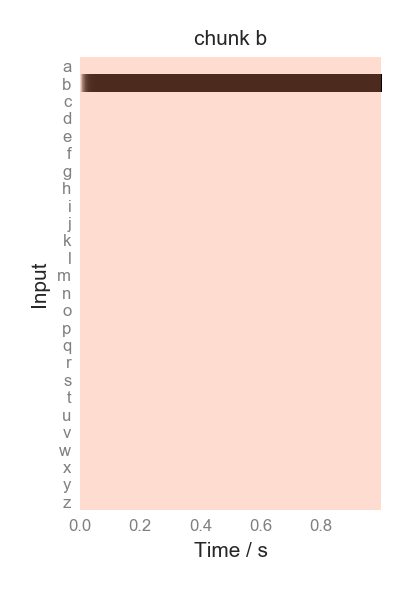

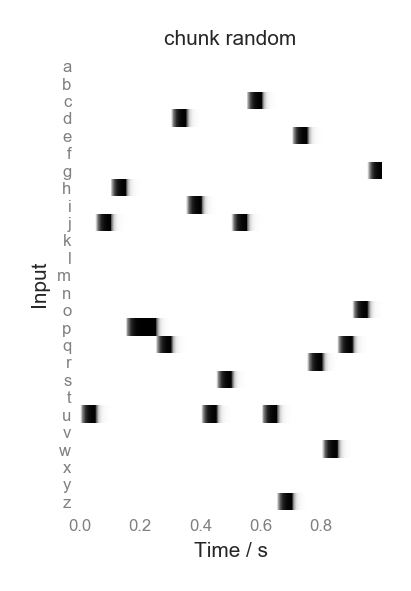

In [8]:
inputParams = defaultInputParams.copy()
inputParams['chunkList'] =[['a','a','a','a','a','a','a','a','a','a'],['b','b','b','b','b','b','b','b','b','b']]
inputParams['interChunkSyllables'] = alphabet[2:]
inputParams['gapRange'] = [15,20]
inputs = getInputs(inputParams,totalTime=400)
plotInputs(inputs,title='Train, 500s')

inputsTest = getInputs(inputParams,totalTime=10)
plotInputs(inputsTest,title='Test, 10s')

inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['a']*20]
inputParams['chunkLabels'] = [0]
inputsTest_a = getInputs(inputParams)
plotInputs(inputsTest_a,title='chunk a')

inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['b']*20]
inputParams['chunkLabels'] = [1]
inputsTest_b = getInputs(inputParams)
plotInputs(inputsTest_b,title='chunk b')

inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [random.choices(inputParams['interChunkSyllables'], k = 20)]
inputParams['chunkLabels'] = ['r']
inputsTest_r = getInputs(inputParams)
plotInputs(inputsTest_r,title='chunk random')

random.choices(alphabet)

In [32]:
hyperparams = {'Ng' : 200, #no. neurons in each reservoir 
               'n' : 100, #no. reservoir neurons the output neuron is connected to 
               'p' : 1, #connection probability amongst recurrent units
               'tau' : 10, #neuron time constant, in ms 
               'dt' : 1, #simulation timestep in ms
               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
               'g_Gz' : 1, #feedback strength,
               'alpha' : 100, #learning rate
               'sigma' : 0.3,#amount of network noise
               'Nz' : 1, #no. of output neurons,
               'ipr' : 3,
               'Ni' : 26} #no. input neurons. Must be consistent with ther inputs passed 
hyperparams['Ni'] = inputs['data'].shape[1]

In [6]:
reservoirPair = ReservoirPair(hyperparams,inputs)
reservoirPair.storeInputs(inputsTest,name='test')
reservoirPair.trainPair()
reservoirPair.testPair(testName='posttraining',testData='test',Ntest=5,returnItems=['z','r'])

NameError: name 'inputs' is not defined

In [19]:
pickleAndSave(reservoirPair,'lyapunov')

In [2]:
reservoirPair = loadAndDepickle('lyapunov')

(<Figure size 1200x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f86fc7549b0>)

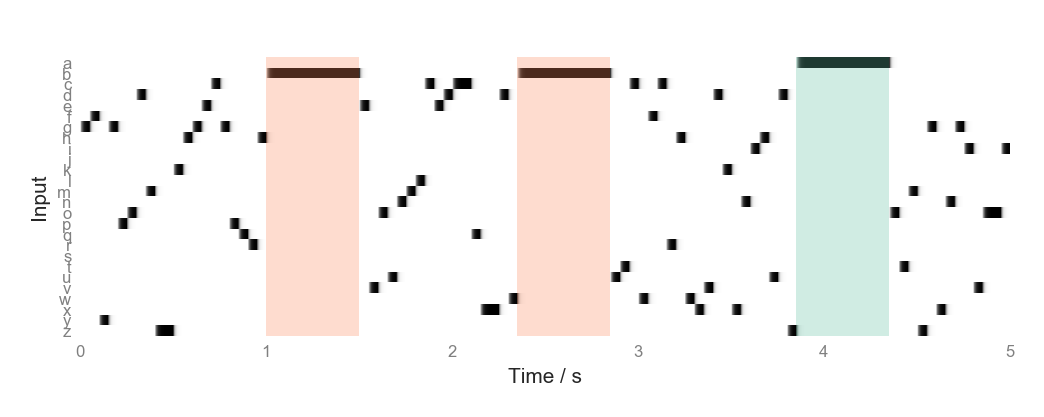

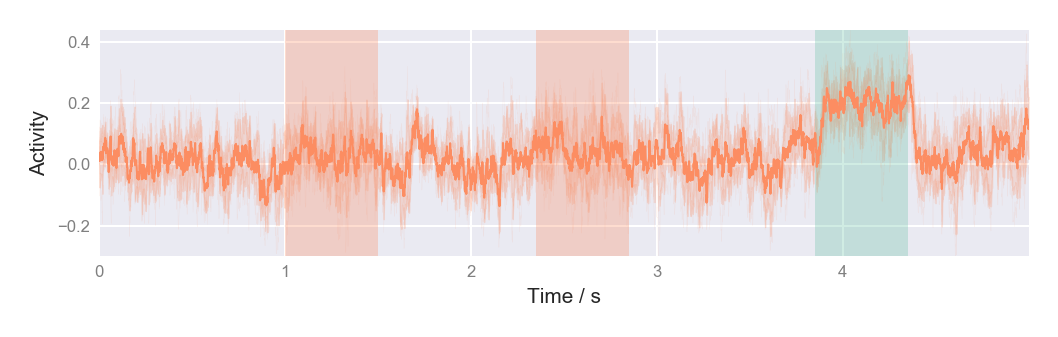

In [10]:
plotInputs(reservoirPair.inputDict['test'])
plotTest(reservoirPair,testName='posttraining',testData='test')

### Find the lyapunov exponent for a standard reservoir net 

g = 2.0:   0%|          | 0/3 [00:00<?, ?it/s]

Performing 30 repeats:   0%|          | 0/30 [00:00<?, ?it/s]

Performing 30 repeats:   0%|          | 0/30 [00:00<?, ?it/s]

Performing 30 repeats:   0%|          | 0/30 [00:00<?, ?it/s]

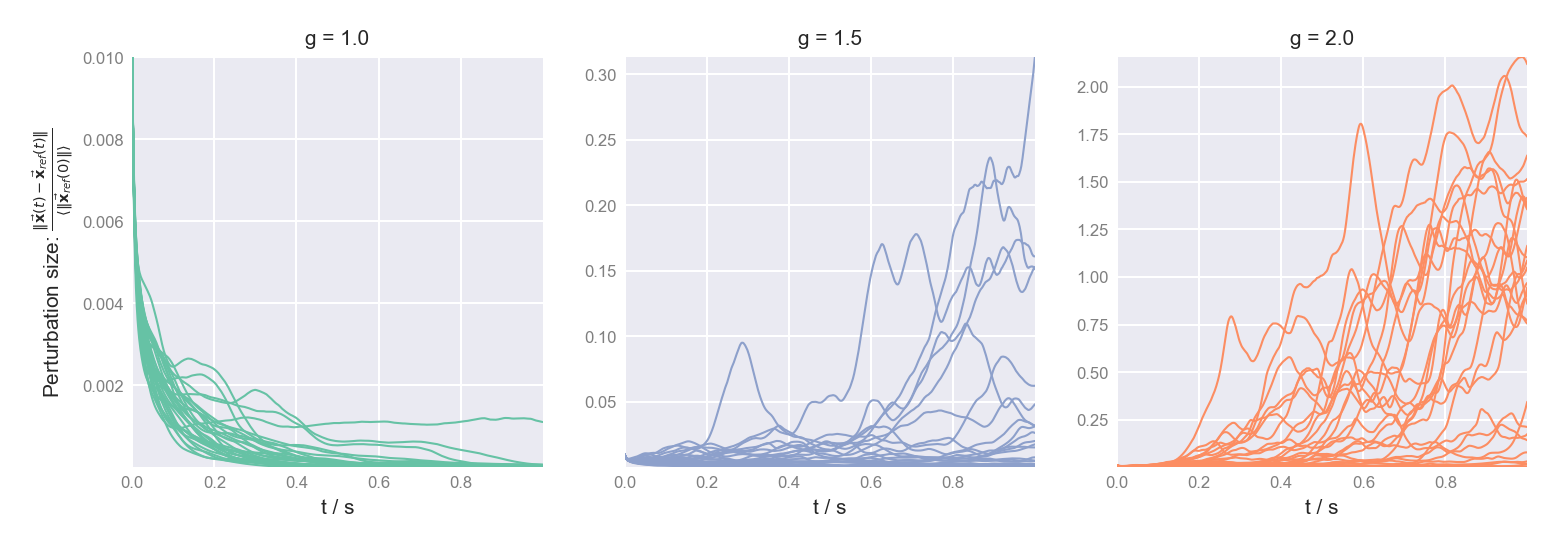

In [383]:
hyperparams = {'Ng' : 200, #no. neurons in each reservoir 
               'n' : 100, #no. reservoir neurons the output neuron is connected to 
               'p' : 1, #connection probability amongst recurrent units
               'tau' : 10, #neuron time constant, in ms 
               'dt' : 1, #simulation timestep in ms
               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
               'g_Gz' : 1, #feedback strength,
               'alpha' : 100, #learning rate
               'sigma' : 0.3,#amount of network noise
               'Nz' : 1, #no. of output neurons,
               'ipr' : 26,
               'Ni' : 26} #no. input neurons. Must be consistent with ther inputs passed 
inputStrength = 0
noiseStrength = 0.2
feedbackStrength = 0

colorList = ['C0','C2','C1']

g_range = [1,1.5,2]
fig,ax = plt.subplots(1,len(g_range),figsize=(2*len(g_range),2))

steps = 1000
nTests = 30
n_g = len(g_range)
t = np.arange(steps+1)*hyperparams['dt']

hyperparams['dt'] = 1
hyperparams['sigma'] *= noiseStrength

animationX = np.zeros(shape=(n_g,steps,nTests,2))
                    
for (i,g) in enumerate(tqdm(g_range,desc='g = %.1f' %g)):
    plotDeviation = np.zeros(shape=(nTests,steps))
    np.random.seed()
    #INITIALISE REFERENSE RESERVOIR AND SPIN IT UP 
    hyperparams['g_GG'] = g

    refRes = Reservoir(hyperparams)
    refRes.J_Gz *= feedbackStrength  #feedback
    refRes.J_GI *= inputStrength #inputs (uniform)

    xav = np.linalg.norm(refRes.x)
    for j in range(1000): #1 seconds spin up
        x = np.linalg.norm(refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Ni']),returnItems=['x'])['x'])
        xav = xav + (1/(j+1))*(x - xav)

    copy_xs = np.zeros(shape=(len(g_range),steps,nTests,2))
    for n in tqdm(range(nTests),leave=False,desc='Performing %g repeats' %nTests):
        np.random.seed()
        refRes = Reservoir(hyperparams)
        refRes.J_Gz *= feedbackStrength  #feedback
        refRes.J_GI *= inputStrength #inputs (uniform)
        for j in range(1000): #1 seconds spin up
            refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Ni']))
        copyRes = copy.deepcopy(refRes)
        perturbation = np.random.randn(res1.Ng)
        perturbation /= np.linalg.norm(perturbation)
        perturbation *= 0.01*xav #random perturbation 10% size of x 
        copyRes.x += perturbation
        
        for s in range(steps):
            animationX[i,s,n,:] = copyRes.x[:2] - refRes.x[:2]
            plotDeviation[n,s] = np.linalg.norm(copyRes.x - refRes.x)
            np.random.seed(s)
            refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Ni']))
            np.random.seed(s)
            copyRes.runDynamicsStep(inputVec=np.ones(hyperparams['Ni']))
 
        ax[i].plot(np.arange(steps)*hyperparams['dt']/1000,plotDeviation[n]/xav,c=colorList[i])
    ax[i].set_xlabel("t / s")
    ax[i].set_title("g = %.1f" %g)
    ax[i].set_aspect((ax[i].get_xlim()[1]-ax[i].get_xlim()[0])/(ax[i].get_ylim()[1]-ax[i].get_ylim()[0]))
        
ax[0].set_ylabel(r"Perturbation size: $\frac{ \Vert \vec{\mathbf{x}}(t) - \vec{\mathbf{x}}_{ref}(t) \Vert }{ \langle \Vert  \vec{\mathbf{x}}_{ref}(0)  \Vert \rangle }$")    
plt.savefig("./figures/chaosdeviation.png",dpi=300)


In [379]:
i = 2
fps = 10
length = 15 #s
writer = anim.FFMpegWriter(fps=fps,bitrate=4000) 
a = AnimatedChaos(data=animationX[i],fps=fps,length=length,xylim=5,color=colorList[i])
a.ani.save('./figures/chaosg20.mp4', writer=writer,dpi=300)



In [380]:
Video("./figures/chaosg20.mp4")

In [ ]:
len(animationX[1][::5])

In [358]:
for i in [0,1,2]:
    ax[i].set_aspect((ax[i].get_xlim()[1]-ax[i].get_xlim()[0])/(ax[i].get_ylim()[1]-ax[i].get_ylim()[0]))

In [360]:
ax[0].set_ylabel(r"Perturbation size: $\frac{ \Vert \vec{\mathbf{x}}(t) - \vec{\mathbf{x}}_{ref}(t) \Vert }{ \langle \Vert  \vec{\mathbf{x}}_{ref}(0)  \Vert \rangle }$",rotation=90)    
plt.savefig("./figures/chaosdeviation.png",dpi=300)

<Figure size 2400x1650 with 0 Axes>